In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16676809915112697877, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1882841478097256032
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np
np.random.seed(777)

import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from tqdm import tqdm

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
output_classes = 2
# batch_size = 4 
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 20

nb_train_samples = 4247
nb_validation_samples = 551
nb_test_samples = 603

In [5]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [6]:
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)

In [7]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/train/ 0
data/train/benign 1485
data/train/malignant 2762
******************************
data/validation 0
data/validation\benign 183
data/validation\malignant 368
******************************
data/test 0
data/test\benign 189
data/test\malignant 414


In [8]:
random_seed = np.random.seed(777)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 4247 images belonging to 2 classes.
Found 551 images belonging to 2 classes.
Found 603 images belonging to 2 classes.


In [9]:
X_train, y_train = [], []
for _ in tqdm(range(nb_train_samples)):
    x, y = train_generator.next()
    X_train.append(x[0])
    y_train.append(y[0])
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
# np.save('data/npy/X_train.npy', X_train)
# np.save('data/npy/y_train.npy', y_train)

100%|█████████████████████████████████████████████████████████████████████████████| 4247/4247 [00:10<00:00, 420.13it/s]


In [10]:
X_validation, y_validation = [], []
for _ in tqdm(range(nb_validation_samples)):
    x_val, y_val = validation_generator.next()
    X_validation.append(x_val[0])
    y_validation.append(y_val[0])
X_validation = np.asarray(X_validation)
y_validation = np.asarray(y_validation)
# np.save('data/npy/X_validation.npy', X_validation)
# np.save('data/npy/y_validation.npy', y_validation)

100%|███████████████████████████████████████████████████████████████████████████████| 551/551 [00:01<00:00, 454.71it/s]


In [11]:
X_test, y_test = [], []
for _ in tqdm(range(nb_test_samples)):
    x_t, y_t = test_generator.next()
    X_test.append(x_t[0])
    y_test.append(y_t[0])
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
# np.save('data/npy/X_test.npy', X_test)
# np.save('data/npy/y_test.npy', y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 603/603 [00:01<00:00, 457.29it/s]


X_train shape: (4247, 224, 224, 3)
y_train shape: (4247, 2)
X_validation shape: (551, 224, 224, 3)
y_validation shape: (551, 2)
X_test shape: (603, 224, 224, 3)
y_test shape: (603, 2)


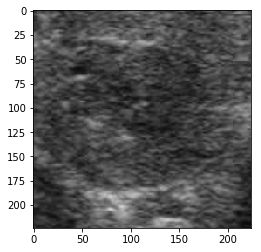

In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

plt.imshow(X_train[0])
plt.show()

In [13]:
from keras.applications import ResNet50
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model_dense_conv = ResNet50(weights='imagenet', include_top=False)  
    #Create your own input format
keras_input = Input(shape= input_shape, name = 'image_input')
    
    #Use the generated model 
output_dense_conv = model_dense_conv(keras_input)
    
    #Add the fully-connected layers 
x = Flatten(name='flatten')(output_dense_conv)
x = Dense(1024, activation= 'relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='fc1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation= 'relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(output_classes, activation='softmax', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='predictions')(x)
    
    #Create your own model 
model = Model(inputs=keras_input, outputs=x)

In [14]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
# sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
# rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer = adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
batch_size = 8

history = model.fit(
  X_train, y_train,
  batch_size = batch_size,
  epochs = epochs,
  verbose=1,
  validation_data = (X_validation, y_validation))

Train on 4247 samples, validate on 551 samples
Epoch 1/20


1624/4247 [==========>...................] - ETA: 3:58:36 - loss: 0.8772 - acc: 0.75 - ETA: 1:59:52 - loss: 1.3280 - acc: 0.68 - ETA: 1:20:18 - loss: 1.1833 - acc: 0.70 - ETA: 1:00:30 - loss: 1.3175 - acc: 0.65 - ETA: 48:37 - loss: 1.4997 - acc: 0.5750 - ETA: 40:42 - loss: 1.4528 - acc: 0.58 - ETA: 35:03 - loss: 1.3746 - acc: 0.60 - ETA: 30:49 - loss: 1.3330 - acc: 0.60 - ETA: 27:31 - loss: 1.4225 - acc: 0.61 - ETA: 24:52 - loss: 1.5027 - acc: 0.57 - ETA: 22:42 - loss: 1.4559 - acc: 0.59 - ETA: 20:54 - loss: 1.5124 - acc: 0.58 - ETA: 19:23 - loss: 1.5106 - acc: 0.59 - ETA: 18:04 - loss: 1.4889 - acc: 0.60 - ETA: 16:56 - loss: 1.4640 - acc: 0.60 - ETA: 15:57 - loss: 1.4653 - acc: 0.60 - ETA: 15:04 - loss: 1.4586 - acc: 0.60 - ETA: 14:17 - loss: 1.4878 - acc: 0.59 - ETA: 13:36 - loss: 1.5217 - acc: 0.57 - ETA: 12:58 - loss: 1.5166 - acc: 0.57 - ETA: 12:24 - loss: 1.5286 - acc: 0.57 - ETA: 11:53 - loss: 1.5013 - acc: 0.57 - ETA: 11:25 - loss: 1.4748 - acc: 0.58 - ETA: 10:59 - loss: 1.4942

4247/4247 [==============================] - ETA: 29s - loss: 1.2938 - acc: 0.65 - ETA: 28s - loss: 1.2939 - acc: 0.65 - ETA: 28s - loss: 1.2945 - acc: 0.65 - ETA: 28s - loss: 1.2949 - acc: 0.65 - ETA: 28s - loss: 1.2965 - acc: 0.65 - ETA: 27s - loss: 1.2979 - acc: 0.65 - ETA: 27s - loss: 1.2988 - acc: 0.65 - ETA: 27s - loss: 1.2965 - acc: 0.65 - ETA: 27s - loss: 1.2969 - acc: 0.65 - ETA: 26s - loss: 1.2956 - acc: 0.65 - ETA: 26s - loss: 1.2934 - acc: 0.65 - ETA: 26s - loss: 1.2936 - acc: 0.65 - ETA: 26s - loss: 1.2934 - acc: 0.65 - ETA: 25s - loss: 1.2929 - acc: 0.65 - ETA: 25s - loss: 1.2939 - acc: 0.65 - ETA: 25s - loss: 1.2937 - acc: 0.65 - ETA: 25s - loss: 1.2934 - acc: 0.65 - ETA: 24s - loss: 1.2931 - acc: 0.65 - ETA: 24s - loss: 1.2917 - acc: 0.65 - ETA: 24s - loss: 1.2896 - acc: 0.65 - ETA: 23s - loss: 1.2884 - acc: 0.65 - ETA: 23s - loss: 1.2892 - acc: 0.65 - ETA: 23s - loss: 1.2885 - acc: 0.65 - ETA: 23s - loss: 1.2872 - acc: 0.65 - ETA: 22s - loss: 1.2869 - acc: 0.65 - ETA: 

1632/4247 [==========>...................] - ETA: 1:32 - loss: 1.4724 - acc: 0.625 - ETA: 1:34 - loss: 0.9246 - acc: 0.812 - ETA: 1:34 - loss: 0.7645 - acc: 0.875 - ETA: 1:34 - loss: 0.7974 - acc: 0.843 - ETA: 1:34 - loss: 0.8050 - acc: 0.825 - ETA: 1:34 - loss: 0.8143 - acc: 0.833 - ETA: 1:33 - loss: 0.8123 - acc: 0.821 - ETA: 1:33 - loss: 0.7820 - acc: 0.828 - ETA: 1:33 - loss: 0.8474 - acc: 0.805 - ETA: 1:32 - loss: 0.9475 - acc: 0.775 - ETA: 1:33 - loss: 0.9033 - acc: 0.795 - ETA: 1:33 - loss: 0.9393 - acc: 0.781 - ETA: 1:32 - loss: 0.9045 - acc: 0.788 - ETA: 1:32 - loss: 0.9443 - acc: 0.776 - ETA: 1:32 - loss: 1.0353 - acc: 0.758 - ETA: 1:32 - loss: 1.0178 - acc: 0.757 - ETA: 1:31 - loss: 1.0205 - acc: 0.757 - ETA: 1:31 - loss: 1.0099 - acc: 0.763 - ETA: 1:31 - loss: 1.0230 - acc: 0.756 - ETA: 1:31 - loss: 1.0402 - acc: 0.756 - ETA: 1:31 - loss: 1.0870 - acc: 0.750 - ETA: 1:31 - loss: 1.0710 - acc: 0.755 - ETA: 1:31 - loss: 1.1283 - acc: 0.744 - ETA: 1:30 - loss: 1.1060 - acc: 0.7

4247/4247 [==============================] - ETA: 20s - loss: 1.0126 - acc: 0.74 - ETA: 20s - loss: 1.0116 - acc: 0.74 - ETA: 19s - loss: 1.0109 - acc: 0.74 - ETA: 19s - loss: 1.0097 - acc: 0.74 - ETA: 19s - loss: 1.0089 - acc: 0.74 - ETA: 19s - loss: 1.0086 - acc: 0.74 - ETA: 19s - loss: 1.0099 - acc: 0.74 - ETA: 18s - loss: 1.0121 - acc: 0.74 - ETA: 18s - loss: 1.0116 - acc: 0.74 - ETA: 18s - loss: 1.0132 - acc: 0.74 - ETA: 18s - loss: 1.0151 - acc: 0.74 - ETA: 18s - loss: 1.0136 - acc: 0.74 - ETA: 18s - loss: 1.0140 - acc: 0.74 - ETA: 17s - loss: 1.0134 - acc: 0.74 - ETA: 17s - loss: 1.0187 - acc: 0.74 - ETA: 17s - loss: 1.0201 - acc: 0.74 - ETA: 17s - loss: 1.0201 - acc: 0.74 - ETA: 17s - loss: 1.0204 - acc: 0.74 - ETA: 16s - loss: 1.0201 - acc: 0.74 - ETA: 16s - loss: 1.0200 - acc: 0.74 - ETA: 16s - loss: 1.0202 - acc: 0.74 - ETA: 16s - loss: 1.0196 - acc: 0.74 - ETA: 16s - loss: 1.0182 - acc: 0.74 - ETA: 15s - loss: 1.0168 - acc: 0.74 - ETA: 15s - loss: 1.0163 - acc: 0.74 - ETA: 

1632/4247 [==========>...................] - ETA: 1:32 - loss: 1.4323 - acc: 0.625 - ETA: 1:34 - loss: 1.0369 - acc: 0.750 - ETA: 1:34 - loss: 1.1907 - acc: 0.708 - ETA: 1:34 - loss: 1.0173 - acc: 0.781 - ETA: 1:34 - loss: 0.9514 - acc: 0.775 - ETA: 1:34 - loss: 1.2169 - acc: 0.750 - ETA: 1:34 - loss: 1.3443 - acc: 0.696 - ETA: 1:34 - loss: 1.2685 - acc: 0.703 - ETA: 1:34 - loss: 1.2252 - acc: 0.694 - ETA: 1:34 - loss: 1.1442 - acc: 0.725 - ETA: 1:34 - loss: 1.1272 - acc: 0.727 - ETA: 1:34 - loss: 1.0669 - acc: 0.750 - ETA: 1:34 - loss: 1.1618 - acc: 0.730 - ETA: 1:33 - loss: 1.1401 - acc: 0.741 - ETA: 1:33 - loss: 1.1017 - acc: 0.750 - ETA: 1:33 - loss: 1.1248 - acc: 0.742 - ETA: 1:33 - loss: 1.1516 - acc: 0.735 - ETA: 1:33 - loss: 1.1338 - acc: 0.736 - ETA: 1:33 - loss: 1.1539 - acc: 0.736 - ETA: 1:32 - loss: 1.2105 - acc: 0.725 - ETA: 1:32 - loss: 1.1775 - acc: 0.732 - ETA: 1:32 - loss: 1.1620 - acc: 0.727 - ETA: 1:32 - loss: 1.1389 - acc: 0.728 - ETA: 1:32 - loss: 1.1118 - acc: 0.7

4247/4247 [==============================] - ETA: 19s - loss: 0.9060 - acc: 0.77 - ETA: 19s - loss: 0.9051 - acc: 0.77 - ETA: 19s - loss: 0.9042 - acc: 0.77 - ETA: 19s - loss: 0.9037 - acc: 0.77 - ETA: 19s - loss: 0.9034 - acc: 0.77 - ETA: 19s - loss: 0.9026 - acc: 0.77 - ETA: 18s - loss: 0.9034 - acc: 0.77 - ETA: 18s - loss: 0.9035 - acc: 0.77 - ETA: 18s - loss: 0.9040 - acc: 0.77 - ETA: 18s - loss: 0.9077 - acc: 0.77 - ETA: 18s - loss: 0.9080 - acc: 0.77 - ETA: 17s - loss: 0.9081 - acc: 0.77 - ETA: 17s - loss: 0.9084 - acc: 0.77 - ETA: 17s - loss: 0.9072 - acc: 0.77 - ETA: 17s - loss: 0.9071 - acc: 0.77 - ETA: 17s - loss: 0.9065 - acc: 0.77 - ETA: 17s - loss: 0.9064 - acc: 0.77 - ETA: 16s - loss: 0.9065 - acc: 0.77 - ETA: 16s - loss: 0.9053 - acc: 0.77 - ETA: 16s - loss: 0.9047 - acc: 0.77 - ETA: 16s - loss: 0.9061 - acc: 0.77 - ETA: 16s - loss: 0.9066 - acc: 0.77 - ETA: 15s - loss: 0.9061 - acc: 0.77 - ETA: 15s - loss: 0.9071 - acc: 0.77 - ETA: 15s - loss: 0.9068 - acc: 0.77 - ETA: 

1640/4247 [==========>...................] - ETA: 1:30 - loss: 1.4388 - acc: 0.625 - ETA: 1:31 - loss: 0.9747 - acc: 0.750 - ETA: 1:31 - loss: 1.1615 - acc: 0.708 - ETA: 1:32 - loss: 1.0457 - acc: 0.750 - ETA: 1:32 - loss: 0.9983 - acc: 0.750 - ETA: 1:32 - loss: 0.9951 - acc: 0.729 - ETA: 1:32 - loss: 1.0844 - acc: 0.714 - ETA: 1:32 - loss: 1.1108 - acc: 0.703 - ETA: 1:32 - loss: 1.1539 - acc: 0.680 - ETA: 1:32 - loss: 1.0813 - acc: 0.712 - ETA: 1:31 - loss: 1.1047 - acc: 0.727 - ETA: 1:31 - loss: 1.0449 - acc: 0.750 - ETA: 1:31 - loss: 1.0026 - acc: 0.759 - ETA: 1:31 - loss: 0.9795 - acc: 0.758 - ETA: 1:31 - loss: 0.9595 - acc: 0.766 - ETA: 1:31 - loss: 0.9272 - acc: 0.781 - ETA: 1:31 - loss: 0.8974 - acc: 0.786 - ETA: 1:31 - loss: 0.9126 - acc: 0.791 - ETA: 1:31 - loss: 0.9230 - acc: 0.776 - ETA: 1:30 - loss: 0.9389 - acc: 0.768 - ETA: 1:30 - loss: 0.9159 - acc: 0.773 - ETA: 1:30 - loss: 0.9337 - acc: 0.767 - ETA: 1:30 - loss: 0.9373 - acc: 0.766 - ETA: 1:30 - loss: 0.9404 - acc: 0.7

4247/4247 [==============================] - ETA: 19s - loss: 0.8282 - acc: 0.81 - ETA: 19s - loss: 0.8279 - acc: 0.81 - ETA: 19s - loss: 0.8290 - acc: 0.80 - ETA: 19s - loss: 0.8278 - acc: 0.81 - ETA: 19s - loss: 0.8280 - acc: 0.81 - ETA: 18s - loss: 0.8270 - acc: 0.81 - ETA: 18s - loss: 0.8274 - acc: 0.81 - ETA: 18s - loss: 0.8263 - acc: 0.81 - ETA: 18s - loss: 0.8259 - acc: 0.81 - ETA: 18s - loss: 0.8265 - acc: 0.81 - ETA: 17s - loss: 0.8260 - acc: 0.81 - ETA: 17s - loss: 0.8278 - acc: 0.80 - ETA: 17s - loss: 0.8270 - acc: 0.80 - ETA: 17s - loss: 0.8279 - acc: 0.80 - ETA: 17s - loss: 0.8284 - acc: 0.80 - ETA: 17s - loss: 0.8284 - acc: 0.80 - ETA: 16s - loss: 0.8292 - acc: 0.80 - ETA: 16s - loss: 0.8288 - acc: 0.80 - ETA: 16s - loss: 0.8287 - acc: 0.80 - ETA: 16s - loss: 0.8277 - acc: 0.80 - ETA: 16s - loss: 0.8273 - acc: 0.80 - ETA: 15s - loss: 0.8266 - acc: 0.80 - ETA: 15s - loss: 0.8259 - acc: 0.80 - ETA: 15s - loss: 0.8260 - acc: 0.80 - ETA: 15s - loss: 0.8254 - acc: 0.80 - ETA: 

1640/4247 [==========>...................] - ETA: 1:31 - loss: 1.3273 - acc: 0.625 - ETA: 1:30 - loss: 0.9820 - acc: 0.687 - ETA: 1:31 - loss: 1.3193 - acc: 0.666 - ETA: 1:31 - loss: 1.0922 - acc: 0.750 - ETA: 1:31 - loss: 0.9937 - acc: 0.775 - ETA: 1:32 - loss: 0.9360 - acc: 0.791 - ETA: 1:32 - loss: 0.9084 - acc: 0.785 - ETA: 1:32 - loss: 0.8396 - acc: 0.812 - ETA: 1:32 - loss: 0.7821 - acc: 0.833 - ETA: 1:32 - loss: 0.7486 - acc: 0.837 - ETA: 1:32 - loss: 0.7131 - acc: 0.852 - ETA: 1:32 - loss: 0.7404 - acc: 0.833 - ETA: 1:32 - loss: 0.7379 - acc: 0.826 - ETA: 1:31 - loss: 0.7142 - acc: 0.839 - ETA: 1:31 - loss: 0.7430 - acc: 0.833 - ETA: 1:31 - loss: 0.7194 - acc: 0.843 - ETA: 1:31 - loss: 0.7180 - acc: 0.845 - ETA: 1:31 - loss: 0.7273 - acc: 0.833 - ETA: 1:31 - loss: 0.7137 - acc: 0.835 - ETA: 1:31 - loss: 0.6956 - acc: 0.843 - ETA: 1:31 - loss: 0.7028 - acc: 0.839 - ETA: 1:31 - loss: 0.6969 - acc: 0.840 - ETA: 1:31 - loss: 0.7047 - acc: 0.831 - ETA: 1:30 - loss: 0.6938 - acc: 0.8

4247/4247 [==============================] - ETA: 19s - loss: 0.7567 - acc: 0.82 - ETA: 19s - loss: 0.7570 - acc: 0.82 - ETA: 19s - loss: 0.7582 - acc: 0.82 - ETA: 19s - loss: 0.7580 - acc: 0.82 - ETA: 18s - loss: 0.7572 - acc: 0.82 - ETA: 18s - loss: 0.7584 - acc: 0.82 - ETA: 18s - loss: 0.7574 - acc: 0.82 - ETA: 18s - loss: 0.7568 - acc: 0.82 - ETA: 18s - loss: 0.7566 - acc: 0.82 - ETA: 18s - loss: 0.7557 - acc: 0.82 - ETA: 17s - loss: 0.7564 - acc: 0.82 - ETA: 17s - loss: 0.7561 - acc: 0.82 - ETA: 17s - loss: 0.7560 - acc: 0.82 - ETA: 17s - loss: 0.7556 - acc: 0.82 - ETA: 17s - loss: 0.7552 - acc: 0.82 - ETA: 17s - loss: 0.7577 - acc: 0.82 - ETA: 16s - loss: 0.7566 - acc: 0.82 - ETA: 16s - loss: 0.7561 - acc: 0.82 - ETA: 16s - loss: 0.7555 - acc: 0.82 - ETA: 16s - loss: 0.7555 - acc: 0.82 - ETA: 16s - loss: 0.7562 - acc: 0.82 - ETA: 15s - loss: 0.7553 - acc: 0.82 - ETA: 15s - loss: 0.7548 - acc: 0.82 - ETA: 15s - loss: 0.7543 - acc: 0.82 - ETA: 15s - loss: 0.7538 - acc: 0.82 - ETA: 

1640/4247 [==========>...................] - ETA: 1:30 - loss: 0.3585 - acc: 1.000 - ETA: 1:31 - loss: 0.3481 - acc: 1.000 - ETA: 1:31 - loss: 0.4756 - acc: 0.916 - ETA: 1:32 - loss: 0.7498 - acc: 0.812 - ETA: 1:32 - loss: 0.8814 - acc: 0.775 - ETA: 1:32 - loss: 0.8014 - acc: 0.812 - ETA: 1:32 - loss: 0.7971 - acc: 0.821 - ETA: 1:32 - loss: 0.7788 - acc: 0.828 - ETA: 1:32 - loss: 0.7552 - acc: 0.819 - ETA: 1:32 - loss: 0.7340 - acc: 0.812 - ETA: 1:32 - loss: 0.8191 - acc: 0.784 - ETA: 1:32 - loss: 0.7817 - acc: 0.802 - ETA: 1:32 - loss: 0.7847 - acc: 0.807 - ETA: 1:31 - loss: 0.7774 - acc: 0.812 - ETA: 1:31 - loss: 0.7501 - acc: 0.825 - ETA: 1:31 - loss: 0.8213 - acc: 0.812 - ETA: 1:31 - loss: 0.7948 - acc: 0.823 - ETA: 1:31 - loss: 0.7763 - acc: 0.826 - ETA: 1:31 - loss: 0.7545 - acc: 0.835 - ETA: 1:31 - loss: 0.7420 - acc: 0.837 - ETA: 1:30 - loss: 0.7442 - acc: 0.839 - ETA: 1:30 - loss: 0.7352 - acc: 0.840 - ETA: 1:30 - loss: 0.7327 - acc: 0.842 - ETA: 1:30 - loss: 0.7669 - acc: 0.8

4247/4247 [==============================] - ETA: 19s - loss: 0.7160 - acc: 0.84 - ETA: 19s - loss: 0.7166 - acc: 0.84 - ETA: 19s - loss: 0.7159 - acc: 0.84 - ETA: 19s - loss: 0.7152 - acc: 0.84 - ETA: 18s - loss: 0.7149 - acc: 0.85 - ETA: 18s - loss: 0.7154 - acc: 0.84 - ETA: 18s - loss: 0.7147 - acc: 0.84 - ETA: 18s - loss: 0.7149 - acc: 0.84 - ETA: 18s - loss: 0.7147 - acc: 0.84 - ETA: 18s - loss: 0.7147 - acc: 0.84 - ETA: 17s - loss: 0.7145 - acc: 0.84 - ETA: 17s - loss: 0.7142 - acc: 0.84 - ETA: 17s - loss: 0.7151 - acc: 0.84 - ETA: 17s - loss: 0.7153 - acc: 0.84 - ETA: 17s - loss: 0.7145 - acc: 0.84 - ETA: 16s - loss: 0.7147 - acc: 0.84 - ETA: 16s - loss: 0.7150 - acc: 0.84 - ETA: 16s - loss: 0.7148 - acc: 0.84 - ETA: 16s - loss: 0.7146 - acc: 0.84 - ETA: 16s - loss: 0.7140 - acc: 0.84 - ETA: 16s - loss: 0.7143 - acc: 0.84 - ETA: 15s - loss: 0.7135 - acc: 0.84 - ETA: 15s - loss: 0.7131 - acc: 0.84 - ETA: 15s - loss: 0.7128 - acc: 0.84 - ETA: 15s - loss: 0.7123 - acc: 0.84 - ETA: 

1640/4247 [==========>...................] - ETA: 1:32 - loss: 0.4428 - acc: 0.875 - ETA: 1:32 - loss: 0.8171 - acc: 0.750 - ETA: 1:33 - loss: 0.6520 - acc: 0.833 - ETA: 1:32 - loss: 0.5875 - acc: 0.875 - ETA: 1:32 - loss: 0.5488 - acc: 0.900 - ETA: 1:32 - loss: 0.5174 - acc: 0.916 - ETA: 1:31 - loss: 0.5131 - acc: 0.928 - ETA: 1:31 - loss: 0.5441 - acc: 0.906 - ETA: 1:31 - loss: 0.5305 - acc: 0.916 - ETA: 1:31 - loss: 0.5128 - acc: 0.925 - ETA: 1:31 - loss: 0.5005 - acc: 0.931 - ETA: 1:31 - loss: 0.4860 - acc: 0.937 - ETA: 1:31 - loss: 0.4820 - acc: 0.932 - ETA: 1:31 - loss: 0.5054 - acc: 0.919 - ETA: 1:31 - loss: 0.5092 - acc: 0.916 - ETA: 1:31 - loss: 0.4990 - acc: 0.921 - ETA: 1:30 - loss: 0.5304 - acc: 0.911 - ETA: 1:30 - loss: 0.5212 - acc: 0.916 - ETA: 1:30 - loss: 0.5395 - acc: 0.914 - ETA: 1:30 - loss: 0.5324 - acc: 0.918 - ETA: 1:30 - loss: 0.5239 - acc: 0.922 - ETA: 1:30 - loss: 0.5196 - acc: 0.926 - ETA: 1:30 - loss: 0.5220 - acc: 0.923 - ETA: 1:30 - loss: 0.5139 - acc: 0.9

4247/4247 [==============================] - ETA: 19s - loss: 0.6806 - acc: 0.86 - ETA: 19s - loss: 0.6797 - acc: 0.86 - ETA: 19s - loss: 0.6792 - acc: 0.86 - ETA: 19s - loss: 0.6796 - acc: 0.86 - ETA: 19s - loss: 0.6793 - acc: 0.86 - ETA: 18s - loss: 0.6804 - acc: 0.86 - ETA: 18s - loss: 0.6801 - acc: 0.86 - ETA: 18s - loss: 0.6793 - acc: 0.86 - ETA: 18s - loss: 0.6792 - acc: 0.86 - ETA: 18s - loss: 0.6789 - acc: 0.86 - ETA: 17s - loss: 0.6782 - acc: 0.86 - ETA: 17s - loss: 0.6779 - acc: 0.86 - ETA: 17s - loss: 0.6776 - acc: 0.86 - ETA: 17s - loss: 0.6773 - acc: 0.86 - ETA: 17s - loss: 0.6767 - acc: 0.86 - ETA: 17s - loss: 0.6787 - acc: 0.86 - ETA: 16s - loss: 0.6789 - acc: 0.86 - ETA: 16s - loss: 0.6784 - acc: 0.86 - ETA: 16s - loss: 0.6778 - acc: 0.86 - ETA: 16s - loss: 0.6776 - acc: 0.86 - ETA: 16s - loss: 0.6775 - acc: 0.86 - ETA: 15s - loss: 0.6776 - acc: 0.86 - ETA: 15s - loss: 0.6770 - acc: 0.86 - ETA: 15s - loss: 0.6774 - acc: 0.86 - ETA: 15s - loss: 0.6767 - acc: 0.86 - ETA: 

1640/4247 [==========>...................] - ETA: 1:32 - loss: 0.4200 - acc: 0.875 - ETA: 1:31 - loss: 0.4528 - acc: 0.937 - ETA: 1:31 - loss: 0.4266 - acc: 0.958 - ETA: 1:31 - loss: 0.4417 - acc: 0.937 - ETA: 1:30 - loss: 0.4189 - acc: 0.950 - ETA: 1:30 - loss: 0.4036 - acc: 0.958 - ETA: 1:30 - loss: 0.5787 - acc: 0.910 - ETA: 1:30 - loss: 0.5799 - acc: 0.906 - ETA: 1:30 - loss: 0.5940 - acc: 0.888 - ETA: 1:30 - loss: 0.7075 - acc: 0.837 - ETA: 1:30 - loss: 0.7285 - acc: 0.818 - ETA: 1:30 - loss: 0.7163 - acc: 0.812 - ETA: 1:29 - loss: 0.7387 - acc: 0.817 - ETA: 1:29 - loss: 0.7089 - acc: 0.830 - ETA: 1:29 - loss: 0.7349 - acc: 0.825 - ETA: 1:29 - loss: 0.7201 - acc: 0.828 - ETA: 1:29 - loss: 0.7070 - acc: 0.838 - ETA: 1:29 - loss: 0.6872 - acc: 0.847 - ETA: 1:29 - loss: 0.6768 - acc: 0.848 - ETA: 1:28 - loss: 0.7115 - acc: 0.843 - ETA: 1:28 - loss: 0.7213 - acc: 0.827 - ETA: 1:28 - loss: 0.7040 - acc: 0.835 - ETA: 1:28 - loss: 0.6941 - acc: 0.837 - ETA: 1:28 - loss: 0.6799 - acc: 0.8

4247/4247 [==============================] - ETA: 19s - loss: 0.6510 - acc: 0.86 - ETA: 19s - loss: 0.6508 - acc: 0.86 - ETA: 19s - loss: 0.6501 - acc: 0.86 - ETA: 19s - loss: 0.6497 - acc: 0.86 - ETA: 18s - loss: 0.6490 - acc: 0.86 - ETA: 18s - loss: 0.6487 - acc: 0.86 - ETA: 18s - loss: 0.6508 - acc: 0.86 - ETA: 18s - loss: 0.6502 - acc: 0.86 - ETA: 18s - loss: 0.6504 - acc: 0.86 - ETA: 17s - loss: 0.6498 - acc: 0.86 - ETA: 17s - loss: 0.6512 - acc: 0.86 - ETA: 17s - loss: 0.6509 - acc: 0.86 - ETA: 17s - loss: 0.6503 - acc: 0.86 - ETA: 17s - loss: 0.6514 - acc: 0.86 - ETA: 17s - loss: 0.6512 - acc: 0.86 - ETA: 16s - loss: 0.6510 - acc: 0.86 - ETA: 16s - loss: 0.6504 - acc: 0.86 - ETA: 16s - loss: 0.6497 - acc: 0.86 - ETA: 16s - loss: 0.6495 - acc: 0.86 - ETA: 16s - loss: 0.6489 - acc: 0.86 - ETA: 15s - loss: 0.6487 - acc: 0.86 - ETA: 15s - loss: 0.6481 - acc: 0.86 - ETA: 15s - loss: 0.6479 - acc: 0.86 - ETA: 15s - loss: 0.6474 - acc: 0.86 - ETA: 15s - loss: 0.6474 - acc: 0.86 - ETA: 

1632/4247 [==========>...................] - ETA: 1:32 - loss: 0.3165 - acc: 1.000 - ETA: 1:33 - loss: 0.3153 - acc: 1.000 - ETA: 1:32 - loss: 0.3270 - acc: 1.000 - ETA: 1:32 - loss: 0.8837 - acc: 0.875 - ETA: 1:33 - loss: 0.8147 - acc: 0.875 - ETA: 1:33 - loss: 0.7716 - acc: 0.875 - ETA: 1:32 - loss: 0.7979 - acc: 0.875 - ETA: 1:33 - loss: 0.7846 - acc: 0.875 - ETA: 1:32 - loss: 0.7840 - acc: 0.861 - ETA: 1:32 - loss: 0.8519 - acc: 0.825 - ETA: 1:32 - loss: 0.8389 - acc: 0.818 - ETA: 1:32 - loss: 0.8089 - acc: 0.822 - ETA: 1:32 - loss: 0.7721 - acc: 0.836 - ETA: 1:32 - loss: 0.7429 - acc: 0.848 - ETA: 1:32 - loss: 0.7152 - acc: 0.858 - ETA: 1:32 - loss: 0.6910 - acc: 0.867 - ETA: 1:32 - loss: 0.6715 - acc: 0.875 - ETA: 1:31 - loss: 0.6660 - acc: 0.875 - ETA: 1:31 - loss: 0.6495 - acc: 0.881 - ETA: 1:31 - loss: 0.6405 - acc: 0.887 - ETA: 1:31 - loss: 0.6280 - acc: 0.892 - ETA: 1:31 - loss: 0.6204 - acc: 0.892 - ETA: 1:30 - loss: 0.6156 - acc: 0.891 - ETA: 1:30 - loss: 0.6032 - acc: 0.8

4247/4247 [==============================] - ETA: 20s - loss: 0.6339 - acc: 0.87 - ETA: 19s - loss: 0.6342 - acc: 0.87 - ETA: 19s - loss: 0.6340 - acc: 0.87 - ETA: 19s - loss: 0.6336 - acc: 0.87 - ETA: 19s - loss: 0.6334 - acc: 0.87 - ETA: 19s - loss: 0.6327 - acc: 0.87 - ETA: 19s - loss: 0.6326 - acc: 0.87 - ETA: 18s - loss: 0.6328 - acc: 0.87 - ETA: 18s - loss: 0.6337 - acc: 0.87 - ETA: 18s - loss: 0.6335 - acc: 0.87 - ETA: 18s - loss: 0.6328 - acc: 0.87 - ETA: 18s - loss: 0.6322 - acc: 0.87 - ETA: 17s - loss: 0.6322 - acc: 0.87 - ETA: 17s - loss: 0.6316 - acc: 0.87 - ETA: 17s - loss: 0.6313 - acc: 0.87 - ETA: 17s - loss: 0.6320 - acc: 0.87 - ETA: 17s - loss: 0.6318 - acc: 0.87 - ETA: 17s - loss: 0.6323 - acc: 0.87 - ETA: 16s - loss: 0.6317 - acc: 0.87 - ETA: 16s - loss: 0.6312 - acc: 0.87 - ETA: 16s - loss: 0.6311 - acc: 0.87 - ETA: 16s - loss: 0.6305 - acc: 0.87 - ETA: 16s - loss: 0.6298 - acc: 0.87 - ETA: 15s - loss: 0.6297 - acc: 0.87 - ETA: 15s - loss: 0.6300 - acc: 0.87 - ETA: 

1632/4247 [==========>...................] - ETA: 1:37 - loss: 0.4125 - acc: 1.000 - ETA: 1:36 - loss: 0.4205 - acc: 1.000 - ETA: 1:36 - loss: 0.4510 - acc: 0.958 - ETA: 1:37 - loss: 0.4178 - acc: 0.968 - ETA: 1:36 - loss: 0.5605 - acc: 0.925 - ETA: 1:36 - loss: 0.5347 - acc: 0.937 - ETA: 1:36 - loss: 0.5762 - acc: 0.892 - ETA: 1:36 - loss: 0.5439 - acc: 0.906 - ETA: 1:36 - loss: 0.5760 - acc: 0.888 - ETA: 1:36 - loss: 0.5513 - acc: 0.900 - ETA: 1:35 - loss: 0.5307 - acc: 0.909 - ETA: 1:35 - loss: 0.5186 - acc: 0.916 - ETA: 1:35 - loss: 0.5228 - acc: 0.903 - ETA: 1:34 - loss: 0.5109 - acc: 0.910 - ETA: 1:34 - loss: 0.4973 - acc: 0.916 - ETA: 1:33 - loss: 0.5348 - acc: 0.906 - ETA: 1:33 - loss: 0.5257 - acc: 0.911 - ETA: 1:33 - loss: 0.5349 - acc: 0.909 - ETA: 1:33 - loss: 0.5282 - acc: 0.914 - ETA: 1:33 - loss: 0.5358 - acc: 0.912 - ETA: 1:33 - loss: 0.5434 - acc: 0.904 - ETA: 1:32 - loss: 0.5339 - acc: 0.909 - ETA: 1:32 - loss: 0.5246 - acc: 0.913 - ETA: 1:32 - loss: 0.5670 - acc: 0.9

4247/4247 [==============================] - ETA: 19s - loss: 0.5956 - acc: 0.88 - ETA: 19s - loss: 0.5950 - acc: 0.89 - ETA: 19s - loss: 0.5948 - acc: 0.89 - ETA: 19s - loss: 0.5948 - acc: 0.89 - ETA: 19s - loss: 0.5963 - acc: 0.88 - ETA: 19s - loss: 0.5957 - acc: 0.89 - ETA: 18s - loss: 0.5951 - acc: 0.89 - ETA: 18s - loss: 0.5953 - acc: 0.89 - ETA: 18s - loss: 0.5950 - acc: 0.89 - ETA: 18s - loss: 0.5944 - acc: 0.89 - ETA: 18s - loss: 0.5938 - acc: 0.89 - ETA: 18s - loss: 0.5932 - acc: 0.89 - ETA: 17s - loss: 0.5928 - acc: 0.89 - ETA: 17s - loss: 0.5942 - acc: 0.89 - ETA: 17s - loss: 0.5936 - acc: 0.89 - ETA: 17s - loss: 0.5936 - acc: 0.89 - ETA: 17s - loss: 0.5945 - acc: 0.89 - ETA: 16s - loss: 0.5954 - acc: 0.89 - ETA: 16s - loss: 0.5967 - acc: 0.89 - ETA: 16s - loss: 0.5963 - acc: 0.89 - ETA: 16s - loss: 0.5957 - acc: 0.89 - ETA: 16s - loss: 0.5956 - acc: 0.89 - ETA: 16s - loss: 0.5950 - acc: 0.89 - ETA: 15s - loss: 0.5944 - acc: 0.89 - ETA: 15s - loss: 0.5960 - acc: 0.89 - ETA: 

1632/4247 [==========>...................] - ETA: 1:32 - loss: 0.3207 - acc: 1.000 - ETA: 1:32 - loss: 0.3194 - acc: 1.000 - ETA: 1:32 - loss: 0.3711 - acc: 0.958 - ETA: 1:32 - loss: 0.3653 - acc: 0.968 - ETA: 1:32 - loss: 0.3702 - acc: 0.975 - ETA: 1:33 - loss: 0.3619 - acc: 0.979 - ETA: 1:32 - loss: 0.3730 - acc: 0.982 - ETA: 1:32 - loss: 0.3746 - acc: 0.984 - ETA: 1:32 - loss: 0.3807 - acc: 0.986 - ETA: 1:33 - loss: 0.3806 - acc: 0.987 - ETA: 1:33 - loss: 0.4066 - acc: 0.977 - ETA: 1:33 - loss: 0.4016 - acc: 0.979 - ETA: 1:33 - loss: 0.4230 - acc: 0.971 - ETA: 1:32 - loss: 0.4166 - acc: 0.973 - ETA: 1:32 - loss: 0.4179 - acc: 0.975 - ETA: 1:32 - loss: 0.4121 - acc: 0.976 - ETA: 1:31 - loss: 0.4102 - acc: 0.977 - ETA: 1:31 - loss: 0.4085 - acc: 0.979 - ETA: 1:31 - loss: 0.4332 - acc: 0.973 - ETA: 1:31 - loss: 0.4547 - acc: 0.962 - ETA: 1:31 - loss: 0.4735 - acc: 0.958 - ETA: 1:31 - loss: 0.4801 - acc: 0.954 - ETA: 1:30 - loss: 0.5365 - acc: 0.929 - ETA: 1:30 - loss: 0.5290 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.5619 - acc: 0.90 - ETA: 19s - loss: 0.5616 - acc: 0.90 - ETA: 19s - loss: 0.5610 - acc: 0.90 - ETA: 19s - loss: 0.5610 - acc: 0.90 - ETA: 19s - loss: 0.5605 - acc: 0.90 - ETA: 19s - loss: 0.5601 - acc: 0.90 - ETA: 19s - loss: 0.5595 - acc: 0.90 - ETA: 18s - loss: 0.5591 - acc: 0.90 - ETA: 18s - loss: 0.5586 - acc: 0.90 - ETA: 18s - loss: 0.5581 - acc: 0.90 - ETA: 18s - loss: 0.5575 - acc: 0.90 - ETA: 18s - loss: 0.5570 - acc: 0.90 - ETA: 17s - loss: 0.5571 - acc: 0.90 - ETA: 17s - loss: 0.5581 - acc: 0.90 - ETA: 17s - loss: 0.5580 - acc: 0.90 - ETA: 17s - loss: 0.5584 - acc: 0.90 - ETA: 17s - loss: 0.5579 - acc: 0.90 - ETA: 17s - loss: 0.5574 - acc: 0.90 - ETA: 16s - loss: 0.5568 - acc: 0.90 - ETA: 16s - loss: 0.5563 - acc: 0.90 - ETA: 16s - loss: 0.5567 - acc: 0.90 - ETA: 16s - loss: 0.5563 - acc: 0.90 - ETA: 16s - loss: 0.5558 - acc: 0.90 - ETA: 15s - loss: 0.5553 - acc: 0.90 - ETA: 15s - loss: 0.5549 - acc: 0.90 - ETA: 

1632/4247 [==========>...................] - ETA: 1:33 - loss: 0.3940 - acc: 1.000 - ETA: 1:34 - loss: 0.8660 - acc: 0.812 - ETA: 1:33 - loss: 0.7165 - acc: 0.833 - ETA: 1:34 - loss: 0.6179 - acc: 0.875 - ETA: 1:34 - loss: 0.5562 - acc: 0.900 - ETA: 1:34 - loss: 0.5154 - acc: 0.916 - ETA: 1:34 - loss: 0.4875 - acc: 0.928 - ETA: 1:34 - loss: 0.4677 - acc: 0.937 - ETA: 1:34 - loss: 0.4603 - acc: 0.944 - ETA: 1:34 - loss: 0.4457 - acc: 0.950 - ETA: 1:34 - loss: 0.4352 - acc: 0.954 - ETA: 1:34 - loss: 0.4296 - acc: 0.958 - ETA: 1:34 - loss: 0.4225 - acc: 0.961 - ETA: 1:33 - loss: 0.4199 - acc: 0.964 - ETA: 1:33 - loss: 0.4136 - acc: 0.966 - ETA: 1:33 - loss: 0.4109 - acc: 0.968 - ETA: 1:33 - loss: 0.4058 - acc: 0.970 - ETA: 1:33 - loss: 0.4389 - acc: 0.951 - ETA: 1:32 - loss: 0.4489 - acc: 0.947 - ETA: 1:32 - loss: 0.4439 - acc: 0.950 - ETA: 1:32 - loss: 0.4379 - acc: 0.952 - ETA: 1:32 - loss: 0.4326 - acc: 0.954 - ETA: 1:32 - loss: 0.4276 - acc: 0.956 - ETA: 1:31 - loss: 0.4271 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.5530 - acc: 0.91 - ETA: 19s - loss: 0.5537 - acc: 0.91 - ETA: 19s - loss: 0.5535 - acc: 0.91 - ETA: 19s - loss: 0.5529 - acc: 0.91 - ETA: 19s - loss: 0.5550 - acc: 0.90 - ETA: 19s - loss: 0.5546 - acc: 0.90 - ETA: 18s - loss: 0.5556 - acc: 0.90 - ETA: 18s - loss: 0.5552 - acc: 0.90 - ETA: 18s - loss: 0.5556 - acc: 0.90 - ETA: 18s - loss: 0.5552 - acc: 0.90 - ETA: 18s - loss: 0.5563 - acc: 0.90 - ETA: 18s - loss: 0.5558 - acc: 0.90 - ETA: 17s - loss: 0.5558 - acc: 0.90 - ETA: 17s - loss: 0.5553 - acc: 0.90 - ETA: 17s - loss: 0.5548 - acc: 0.90 - ETA: 17s - loss: 0.5545 - acc: 0.90 - ETA: 17s - loss: 0.5541 - acc: 0.91 - ETA: 16s - loss: 0.5537 - acc: 0.91 - ETA: 16s - loss: 0.5532 - acc: 0.91 - ETA: 16s - loss: 0.5527 - acc: 0.91 - ETA: 16s - loss: 0.5522 - acc: 0.91 - ETA: 16s - loss: 0.5517 - acc: 0.91 - ETA: 16s - loss: 0.5516 - acc: 0.91 - ETA: 15s - loss: 0.5519 - acc: 0.91 - ETA: 15s - loss: 0.5517 - acc: 0.91 - ETA: 

1640/4247 [==========>...................] - ETA: 1:27 - loss: 0.3446 - acc: 1.000 - ETA: 1:28 - loss: 0.3377 - acc: 1.000 - ETA: 1:30 - loss: 0.3316 - acc: 1.000 - ETA: 1:31 - loss: 0.3748 - acc: 0.968 - ETA: 1:31 - loss: 0.4497 - acc: 0.950 - ETA: 1:31 - loss: 0.4400 - acc: 0.958 - ETA: 1:31 - loss: 0.4218 - acc: 0.964 - ETA: 1:32 - loss: 0.4265 - acc: 0.953 - ETA: 1:32 - loss: 0.4165 - acc: 0.958 - ETA: 1:32 - loss: 0.4708 - acc: 0.937 - ETA: 1:32 - loss: 0.4579 - acc: 0.943 - ETA: 1:32 - loss: 0.4653 - acc: 0.937 - ETA: 1:31 - loss: 0.4536 - acc: 0.942 - ETA: 1:31 - loss: 0.4439 - acc: 0.946 - ETA: 1:31 - loss: 0.4784 - acc: 0.941 - ETA: 1:31 - loss: 0.4734 - acc: 0.937 - ETA: 1:31 - loss: 0.4713 - acc: 0.933 - ETA: 1:31 - loss: 0.4638 - acc: 0.937 - ETA: 1:31 - loss: 0.4757 - acc: 0.934 - ETA: 1:30 - loss: 0.4684 - acc: 0.937 - ETA: 1:30 - loss: 0.4633 - acc: 0.940 - ETA: 1:30 - loss: 0.4570 - acc: 0.943 - ETA: 1:30 - loss: 0.4704 - acc: 0.940 - ETA: 1:30 - loss: 0.4666 - acc: 0.9

4247/4247 [==============================] - ETA: 19s - loss: 0.5093 - acc: 0.92 - ETA: 19s - loss: 0.5094 - acc: 0.92 - ETA: 19s - loss: 0.5090 - acc: 0.92 - ETA: 19s - loss: 0.5086 - acc: 0.92 - ETA: 18s - loss: 0.5100 - acc: 0.92 - ETA: 18s - loss: 0.5097 - acc: 0.92 - ETA: 18s - loss: 0.5098 - acc: 0.92 - ETA: 18s - loss: 0.5108 - acc: 0.92 - ETA: 18s - loss: 0.5104 - acc: 0.92 - ETA: 18s - loss: 0.5100 - acc: 0.92 - ETA: 17s - loss: 0.5096 - acc: 0.92 - ETA: 17s - loss: 0.5106 - acc: 0.92 - ETA: 17s - loss: 0.5104 - acc: 0.92 - ETA: 17s - loss: 0.5127 - acc: 0.92 - ETA: 17s - loss: 0.5123 - acc: 0.92 - ETA: 17s - loss: 0.5141 - acc: 0.91 - ETA: 16s - loss: 0.5138 - acc: 0.91 - ETA: 16s - loss: 0.5134 - acc: 0.92 - ETA: 16s - loss: 0.5158 - acc: 0.91 - ETA: 16s - loss: 0.5156 - acc: 0.91 - ETA: 16s - loss: 0.5163 - acc: 0.91 - ETA: 15s - loss: 0.5175 - acc: 0.91 - ETA: 15s - loss: 0.5170 - acc: 0.91 - ETA: 15s - loss: 0.5188 - acc: 0.91 - ETA: 15s - loss: 0.5183 - acc: 0.91 - ETA: 

1640/4247 [==========>...................] - ETA: 1:33 - loss: 0.3626 - acc: 1.000 - ETA: 1:32 - loss: 0.3707 - acc: 1.000 - ETA: 1:33 - loss: 0.3559 - acc: 1.000 - ETA: 1:33 - loss: 0.3517 - acc: 1.000 - ETA: 1:33 - loss: 0.3510 - acc: 1.000 - ETA: 1:33 - loss: 0.3577 - acc: 1.000 - ETA: 1:32 - loss: 0.3518 - acc: 1.000 - ETA: 1:32 - loss: 0.3931 - acc: 0.984 - ETA: 1:32 - loss: 0.4685 - acc: 0.972 - ETA: 1:32 - loss: 0.4669 - acc: 0.962 - ETA: 1:32 - loss: 0.4600 - acc: 0.965 - ETA: 1:32 - loss: 0.4990 - acc: 0.958 - ETA: 1:32 - loss: 0.5095 - acc: 0.951 - ETA: 1:32 - loss: 0.4973 - acc: 0.955 - ETA: 1:31 - loss: 0.4878 - acc: 0.958 - ETA: 1:31 - loss: 0.5732 - acc: 0.945 - ETA: 1:31 - loss: 0.5635 - acc: 0.941 - ETA: 1:31 - loss: 0.5511 - acc: 0.944 - ETA: 1:31 - loss: 0.5477 - acc: 0.940 - ETA: 1:31 - loss: 0.5357 - acc: 0.943 - ETA: 1:31 - loss: 0.5301 - acc: 0.946 - ETA: 1:30 - loss: 0.5272 - acc: 0.943 - ETA: 1:30 - loss: 0.5197 - acc: 0.945 - ETA: 1:30 - loss: 0.5111 - acc: 0.9

4247/4247 [==============================] - ETA: 19s - loss: 0.5438 - acc: 0.91 - ETA: 19s - loss: 0.5448 - acc: 0.91 - ETA: 19s - loss: 0.5443 - acc: 0.91 - ETA: 19s - loss: 0.5443 - acc: 0.91 - ETA: 18s - loss: 0.5450 - acc: 0.91 - ETA: 18s - loss: 0.5446 - acc: 0.91 - ETA: 18s - loss: 0.5441 - acc: 0.91 - ETA: 18s - loss: 0.5436 - acc: 0.91 - ETA: 18s - loss: 0.5433 - acc: 0.91 - ETA: 18s - loss: 0.5438 - acc: 0.91 - ETA: 17s - loss: 0.5434 - acc: 0.91 - ETA: 17s - loss: 0.5429 - acc: 0.91 - ETA: 17s - loss: 0.5430 - acc: 0.91 - ETA: 17s - loss: 0.5426 - acc: 0.91 - ETA: 17s - loss: 0.5425 - acc: 0.91 - ETA: 17s - loss: 0.5421 - acc: 0.91 - ETA: 16s - loss: 0.5417 - acc: 0.91 - ETA: 16s - loss: 0.5412 - acc: 0.91 - ETA: 16s - loss: 0.5409 - acc: 0.91 - ETA: 16s - loss: 0.5405 - acc: 0.91 - ETA: 16s - loss: 0.5409 - acc: 0.91 - ETA: 15s - loss: 0.5404 - acc: 0.91 - ETA: 15s - loss: 0.5407 - acc: 0.91 - ETA: 15s - loss: 0.5410 - acc: 0.91 - ETA: 15s - loss: 0.5426 - acc: 0.91 - ETA: 

1640/4247 [==========>...................] - ETA: 1:31 - loss: 0.3485 - acc: 1.000 - ETA: 1:31 - loss: 0.3550 - acc: 1.000 - ETA: 1:32 - loss: 0.5361 - acc: 0.958 - ETA: 1:32 - loss: 0.4904 - acc: 0.968 - ETA: 1:32 - loss: 0.4968 - acc: 0.950 - ETA: 1:33 - loss: 0.5028 - acc: 0.937 - ETA: 1:33 - loss: 0.5842 - acc: 0.910 - ETA: 1:32 - loss: 0.5565 - acc: 0.921 - ETA: 1:32 - loss: 0.5299 - acc: 0.930 - ETA: 1:32 - loss: 0.5418 - acc: 0.925 - ETA: 1:32 - loss: 0.5245 - acc: 0.931 - ETA: 1:32 - loss: 0.5104 - acc: 0.937 - ETA: 1:32 - loss: 0.4968 - acc: 0.942 - ETA: 1:31 - loss: 0.5669 - acc: 0.928 - ETA: 1:31 - loss: 0.5499 - acc: 0.933 - ETA: 1:31 - loss: 0.5350 - acc: 0.937 - ETA: 1:31 - loss: 0.5295 - acc: 0.933 - ETA: 1:31 - loss: 0.5200 - acc: 0.937 - ETA: 1:31 - loss: 0.5165 - acc: 0.940 - ETA: 1:31 - loss: 0.5072 - acc: 0.943 - ETA: 1:30 - loss: 0.4980 - acc: 0.946 - ETA: 1:30 - loss: 0.4895 - acc: 0.948 - ETA: 1:30 - loss: 0.5198 - acc: 0.940 - ETA: 1:30 - loss: 0.5203 - acc: 0.9

4247/4247 [==============================] - ETA: 19s - loss: 0.5163 - acc: 0.92 - ETA: 19s - loss: 0.5165 - acc: 0.92 - ETA: 19s - loss: 0.5160 - acc: 0.92 - ETA: 19s - loss: 0.5156 - acc: 0.92 - ETA: 19s - loss: 0.5151 - acc: 0.92 - ETA: 18s - loss: 0.5152 - acc: 0.92 - ETA: 18s - loss: 0.5147 - acc: 0.92 - ETA: 18s - loss: 0.5142 - acc: 0.92 - ETA: 18s - loss: 0.5138 - acc: 0.92 - ETA: 18s - loss: 0.5149 - acc: 0.92 - ETA: 17s - loss: 0.5145 - acc: 0.92 - ETA: 17s - loss: 0.5140 - acc: 0.92 - ETA: 17s - loss: 0.5140 - acc: 0.92 - ETA: 17s - loss: 0.5136 - acc: 0.92 - ETA: 17s - loss: 0.5133 - acc: 0.92 - ETA: 17s - loss: 0.5133 - acc: 0.92 - ETA: 16s - loss: 0.5129 - acc: 0.92 - ETA: 16s - loss: 0.5133 - acc: 0.92 - ETA: 16s - loss: 0.5129 - acc: 0.92 - ETA: 16s - loss: 0.5124 - acc: 0.92 - ETA: 16s - loss: 0.5123 - acc: 0.92 - ETA: 16s - loss: 0.5120 - acc: 0.92 - ETA: 15s - loss: 0.5115 - acc: 0.92 - ETA: 15s - loss: 0.5114 - acc: 0.92 - ETA: 15s - loss: 0.5111 - acc: 0.92 - ETA: 

1632/4247 [==========>...................] - ETA: 1:29 - loss: 0.3188 - acc: 1.000 - ETA: 1:31 - loss: 0.3590 - acc: 1.000 - ETA: 1:32 - loss: 0.3472 - acc: 1.000 - ETA: 1:32 - loss: 0.3622 - acc: 1.000 - ETA: 1:32 - loss: 0.4081 - acc: 0.950 - ETA: 1:33 - loss: 0.4112 - acc: 0.958 - ETA: 1:33 - loss: 0.4038 - acc: 0.964 - ETA: 1:33 - loss: 0.4393 - acc: 0.937 - ETA: 1:33 - loss: 0.4251 - acc: 0.944 - ETA: 1:34 - loss: 0.4136 - acc: 0.950 - ETA: 1:33 - loss: 0.4048 - acc: 0.954 - ETA: 1:33 - loss: 0.4049 - acc: 0.947 - ETA: 1:33 - loss: 0.4457 - acc: 0.932 - ETA: 1:32 - loss: 0.4488 - acc: 0.928 - ETA: 1:32 - loss: 0.4519 - acc: 0.925 - ETA: 1:32 - loss: 0.4431 - acc: 0.929 - ETA: 1:32 - loss: 0.4396 - acc: 0.933 - ETA: 1:32 - loss: 0.4323 - acc: 0.937 - ETA: 1:31 - loss: 0.4509 - acc: 0.934 - ETA: 1:31 - loss: 0.4439 - acc: 0.937 - ETA: 1:31 - loss: 0.4378 - acc: 0.940 - ETA: 1:31 - loss: 0.4499 - acc: 0.937 - ETA: 1:30 - loss: 0.4568 - acc: 0.934 - ETA: 1:31 - loss: 0.4510 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.4869 - acc: 0.93 - ETA: 19s - loss: 0.4866 - acc: 0.93 - ETA: 19s - loss: 0.4866 - acc: 0.93 - ETA: 19s - loss: 0.4863 - acc: 0.93 - ETA: 19s - loss: 0.4859 - acc: 0.93 - ETA: 19s - loss: 0.4887 - acc: 0.93 - ETA: 19s - loss: 0.4885 - acc: 0.93 - ETA: 18s - loss: 0.4881 - acc: 0.93 - ETA: 18s - loss: 0.4882 - acc: 0.93 - ETA: 18s - loss: 0.4879 - acc: 0.93 - ETA: 18s - loss: 0.4879 - acc: 0.93 - ETA: 18s - loss: 0.4883 - acc: 0.93 - ETA: 17s - loss: 0.4881 - acc: 0.93 - ETA: 17s - loss: 0.4877 - acc: 0.93 - ETA: 17s - loss: 0.4873 - acc: 0.93 - ETA: 17s - loss: 0.4869 - acc: 0.93 - ETA: 17s - loss: 0.4866 - acc: 0.93 - ETA: 17s - loss: 0.4864 - acc: 0.93 - ETA: 16s - loss: 0.4861 - acc: 0.93 - ETA: 16s - loss: 0.4861 - acc: 0.93 - ETA: 16s - loss: 0.4859 - acc: 0.93 - ETA: 16s - loss: 0.4856 - acc: 0.93 - ETA: 16s - loss: 0.4872 - acc: 0.93 - ETA: 16s - loss: 0.4870 - acc: 0.93 - ETA: 15s - loss: 0.4869 - acc: 0.93 - ETA: 

1632/4247 [==========>...................] - ETA: 1:33 - loss: 0.3138 - acc: 1.000 - ETA: 1:32 - loss: 0.3722 - acc: 0.937 - ETA: 1:33 - loss: 0.3522 - acc: 0.958 - ETA: 1:33 - loss: 0.3654 - acc: 0.968 - ETA: 1:34 - loss: 0.3643 - acc: 0.975 - ETA: 1:34 - loss: 0.3972 - acc: 0.958 - ETA: 1:34 - loss: 0.4043 - acc: 0.946 - ETA: 1:34 - loss: 0.3925 - acc: 0.953 - ETA: 1:34 - loss: 0.3922 - acc: 0.958 - ETA: 1:34 - loss: 0.3851 - acc: 0.962 - ETA: 1:34 - loss: 0.3986 - acc: 0.954 - ETA: 1:34 - loss: 0.3999 - acc: 0.958 - ETA: 1:34 - loss: 0.3932 - acc: 0.961 - ETA: 1:33 - loss: 0.4011 - acc: 0.955 - ETA: 1:33 - loss: 0.4160 - acc: 0.950 - ETA: 1:33 - loss: 0.4114 - acc: 0.953 - ETA: 1:33 - loss: 0.4601 - acc: 0.941 - ETA: 1:33 - loss: 0.4567 - acc: 0.944 - ETA: 1:33 - loss: 0.4575 - acc: 0.947 - ETA: 1:32 - loss: 0.4790 - acc: 0.937 - ETA: 1:32 - loss: 0.4770 - acc: 0.940 - ETA: 1:32 - loss: 0.4774 - acc: 0.937 - ETA: 1:32 - loss: 0.4701 - acc: 0.940 - ETA: 1:32 - loss: 0.4651 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.4855 - acc: 0.93 - ETA: 20s - loss: 0.4851 - acc: 0.93 - ETA: 19s - loss: 0.4848 - acc: 0.93 - ETA: 19s - loss: 0.4852 - acc: 0.93 - ETA: 19s - loss: 0.4849 - acc: 0.93 - ETA: 19s - loss: 0.4845 - acc: 0.93 - ETA: 19s - loss: 0.4842 - acc: 0.93 - ETA: 18s - loss: 0.4838 - acc: 0.93 - ETA: 18s - loss: 0.4834 - acc: 0.93 - ETA: 18s - loss: 0.4832 - acc: 0.93 - ETA: 18s - loss: 0.4829 - acc: 0.93 - ETA: 18s - loss: 0.4826 - acc: 0.93 - ETA: 18s - loss: 0.4822 - acc: 0.93 - ETA: 17s - loss: 0.4837 - acc: 0.93 - ETA: 17s - loss: 0.4833 - acc: 0.93 - ETA: 17s - loss: 0.4833 - acc: 0.93 - ETA: 17s - loss: 0.4835 - acc: 0.93 - ETA: 17s - loss: 0.4839 - acc: 0.93 - ETA: 16s - loss: 0.4835 - acc: 0.93 - ETA: 16s - loss: 0.4831 - acc: 0.93 - ETA: 16s - loss: 0.4827 - acc: 0.93 - ETA: 16s - loss: 0.4831 - acc: 0.93 - ETA: 16s - loss: 0.4828 - acc: 0.93 - ETA: 16s - loss: 0.4825 - acc: 0.93 - ETA: 15s - loss: 0.4847 - acc: 0.93 - ETA: 

1632/4247 [==========>...................] - ETA: 1:34 - loss: 0.3120 - acc: 1.000 - ETA: 1:33 - loss: 0.3106 - acc: 1.000 - ETA: 1:33 - loss: 0.3129 - acc: 1.000 - ETA: 1:34 - loss: 0.4619 - acc: 0.937 - ETA: 1:34 - loss: 0.4311 - acc: 0.950 - ETA: 1:34 - loss: 0.4127 - acc: 0.958 - ETA: 1:33 - loss: 0.4016 - acc: 0.964 - ETA: 1:33 - loss: 0.3978 - acc: 0.968 - ETA: 1:33 - loss: 0.4280 - acc: 0.958 - ETA: 1:32 - loss: 0.4267 - acc: 0.962 - ETA: 1:32 - loss: 0.4232 - acc: 0.965 - ETA: 1:32 - loss: 0.4136 - acc: 0.968 - ETA: 1:32 - loss: 0.4109 - acc: 0.971 - ETA: 1:32 - loss: 0.4816 - acc: 0.955 - ETA: 1:32 - loss: 0.4720 - acc: 0.958 - ETA: 1:32 - loss: 0.4688 - acc: 0.960 - ETA: 1:32 - loss: 0.4598 - acc: 0.963 - ETA: 1:32 - loss: 0.4518 - acc: 0.965 - ETA: 1:32 - loss: 0.4473 - acc: 0.967 - ETA: 1:32 - loss: 0.4492 - acc: 0.962 - ETA: 1:32 - loss: 0.4426 - acc: 0.964 - ETA: 1:31 - loss: 0.4605 - acc: 0.960 - ETA: 1:31 - loss: 0.4541 - acc: 0.962 - ETA: 1:31 - loss: 0.4484 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.4990 - acc: 0.93 - ETA: 19s - loss: 0.4987 - acc: 0.93 - ETA: 19s - loss: 0.4982 - acc: 0.93 - ETA: 19s - loss: 0.4978 - acc: 0.93 - ETA: 19s - loss: 0.4982 - acc: 0.93 - ETA: 19s - loss: 0.4978 - acc: 0.93 - ETA: 19s - loss: 0.4976 - acc: 0.93 - ETA: 18s - loss: 0.4972 - acc: 0.93 - ETA: 18s - loss: 0.4968 - acc: 0.93 - ETA: 18s - loss: 0.4979 - acc: 0.93 - ETA: 18s - loss: 0.4976 - acc: 0.93 - ETA: 18s - loss: 0.4972 - acc: 0.93 - ETA: 17s - loss: 0.4982 - acc: 0.93 - ETA: 17s - loss: 0.4982 - acc: 0.93 - ETA: 17s - loss: 0.4977 - acc: 0.93 - ETA: 17s - loss: 0.4983 - acc: 0.93 - ETA: 17s - loss: 0.4981 - acc: 0.93 - ETA: 17s - loss: 0.4977 - acc: 0.93 - ETA: 16s - loss: 0.4973 - acc: 0.93 - ETA: 16s - loss: 0.4970 - acc: 0.93 - ETA: 16s - loss: 0.4966 - acc: 0.93 - ETA: 16s - loss: 0.4962 - acc: 0.93 - ETA: 16s - loss: 0.4959 - acc: 0.93 - ETA: 15s - loss: 0.4957 - acc: 0.93 - ETA: 15s - loss: 0.4952 - acc: 0.93 - ETA: 

1632/4247 [==========>...................] - ETA: 1:35 - loss: 0.8048 - acc: 0.875 - ETA: 1:35 - loss: 0.5717 - acc: 0.937 - ETA: 1:35 - loss: 0.5733 - acc: 0.916 - ETA: 1:35 - loss: 0.5284 - acc: 0.937 - ETA: 1:35 - loss: 0.4887 - acc: 0.950 - ETA: 1:35 - loss: 0.5199 - acc: 0.937 - ETA: 1:35 - loss: 0.6289 - acc: 0.892 - ETA: 1:34 - loss: 0.5955 - acc: 0.906 - ETA: 1:34 - loss: 0.5634 - acc: 0.916 - ETA: 1:34 - loss: 0.6132 - acc: 0.912 - ETA: 1:33 - loss: 0.5907 - acc: 0.920 - ETA: 1:33 - loss: 0.5678 - acc: 0.927 - ETA: 1:33 - loss: 0.5477 - acc: 0.932 - ETA: 1:32 - loss: 0.5804 - acc: 0.919 - ETA: 1:32 - loss: 0.5625 - acc: 0.925 - ETA: 1:32 - loss: 0.5468 - acc: 0.929 - ETA: 1:32 - loss: 0.5512 - acc: 0.926 - ETA: 1:32 - loss: 0.5383 - acc: 0.930 - ETA: 1:32 - loss: 0.5275 - acc: 0.934 - ETA: 1:32 - loss: 0.5372 - acc: 0.931 - ETA: 1:31 - loss: 0.5475 - acc: 0.928 - ETA: 1:31 - loss: 0.5461 - acc: 0.926 - ETA: 1:31 - loss: 0.5591 - acc: 0.923 - ETA: 1:31 - loss: 0.5489 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.4753 - acc: 0.94 - ETA: 20s - loss: 0.4750 - acc: 0.94 - ETA: 19s - loss: 0.4758 - acc: 0.94 - ETA: 19s - loss: 0.4767 - acc: 0.94 - ETA: 19s - loss: 0.4765 - acc: 0.94 - ETA: 19s - loss: 0.4761 - acc: 0.94 - ETA: 19s - loss: 0.4771 - acc: 0.94 - ETA: 18s - loss: 0.4768 - acc: 0.94 - ETA: 18s - loss: 0.4764 - acc: 0.94 - ETA: 18s - loss: 0.4761 - acc: 0.94 - ETA: 18s - loss: 0.4758 - acc: 0.94 - ETA: 18s - loss: 0.4756 - acc: 0.94 - ETA: 18s - loss: 0.4753 - acc: 0.94 - ETA: 17s - loss: 0.4753 - acc: 0.94 - ETA: 17s - loss: 0.4749 - acc: 0.94 - ETA: 17s - loss: 0.4745 - acc: 0.94 - ETA: 17s - loss: 0.4757 - acc: 0.94 - ETA: 17s - loss: 0.4754 - acc: 0.94 - ETA: 16s - loss: 0.4750 - acc: 0.94 - ETA: 16s - loss: 0.4748 - acc: 0.94 - ETA: 16s - loss: 0.4744 - acc: 0.94 - ETA: 16s - loss: 0.4741 - acc: 0.94 - ETA: 16s - loss: 0.4745 - acc: 0.94 - ETA: 16s - loss: 0.4746 - acc: 0.94 - ETA: 15s - loss: 0.4759 - acc: 0.94 - ETA: 

1632/4247 [==========>...................] - ETA: 1:32 - loss: 0.3458 - acc: 1.000 - ETA: 1:38 - loss: 0.3446 - acc: 1.000 - ETA: 1:38 - loss: 0.3335 - acc: 1.000 - ETA: 1:36 - loss: 0.3306 - acc: 1.000 - ETA: 1:36 - loss: 0.3305 - acc: 1.000 - ETA: 1:35 - loss: 0.3278 - acc: 1.000 - ETA: 1:36 - loss: 0.3529 - acc: 0.982 - ETA: 1:35 - loss: 0.3472 - acc: 0.984 - ETA: 1:35 - loss: 0.3496 - acc: 0.986 - ETA: 1:35 - loss: 0.3455 - acc: 0.987 - ETA: 1:35 - loss: 0.3503 - acc: 0.988 - ETA: 1:34 - loss: 0.3489 - acc: 0.989 - ETA: 1:34 - loss: 0.3462 - acc: 0.990 - ETA: 1:34 - loss: 0.3756 - acc: 0.982 - ETA: 1:33 - loss: 0.3727 - acc: 0.983 - ETA: 1:33 - loss: 0.3758 - acc: 0.976 - ETA: 1:33 - loss: 0.3836 - acc: 0.970 - ETA: 1:33 - loss: 0.4034 - acc: 0.958 - ETA: 1:33 - loss: 0.3987 - acc: 0.960 - ETA: 1:33 - loss: 0.3962 - acc: 0.962 - ETA: 1:33 - loss: 0.3932 - acc: 0.964 - ETA: 1:33 - loss: 0.3897 - acc: 0.965 - ETA: 1:32 - loss: 0.4063 - acc: 0.956 - ETA: 1:32 - loss: 0.4022 - acc: 0.9

4247/4247 [==============================] - ETA: 20s - loss: 0.5013 - acc: 0.93 - ETA: 19s - loss: 0.5009 - acc: 0.93 - ETA: 19s - loss: 0.5018 - acc: 0.93 - ETA: 19s - loss: 0.5043 - acc: 0.93 - ETA: 19s - loss: 0.5051 - acc: 0.93 - ETA: 19s - loss: 0.5046 - acc: 0.93 - ETA: 19s - loss: 0.5048 - acc: 0.93 - ETA: 18s - loss: 0.5050 - acc: 0.93 - ETA: 18s - loss: 0.5046 - acc: 0.93 - ETA: 18s - loss: 0.5042 - acc: 0.93 - ETA: 18s - loss: 0.5037 - acc: 0.93 - ETA: 18s - loss: 0.5033 - acc: 0.93 - ETA: 17s - loss: 0.5030 - acc: 0.93 - ETA: 17s - loss: 0.5026 - acc: 0.93 - ETA: 17s - loss: 0.5022 - acc: 0.93 - ETA: 17s - loss: 0.5018 - acc: 0.93 - ETA: 17s - loss: 0.5014 - acc: 0.93 - ETA: 17s - loss: 0.5014 - acc: 0.93 - ETA: 16s - loss: 0.5010 - acc: 0.93 - ETA: 16s - loss: 0.5012 - acc: 0.93 - ETA: 16s - loss: 0.5011 - acc: 0.93 - ETA: 16s - loss: 0.5014 - acc: 0.93 - ETA: 16s - loss: 0.5010 - acc: 0.93 - ETA: 15s - loss: 0.5007 - acc: 0.93 - ETA: 15s - loss: 0.5013 - acc: 0.93 - ETA: 

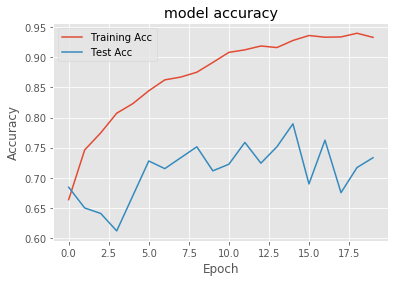

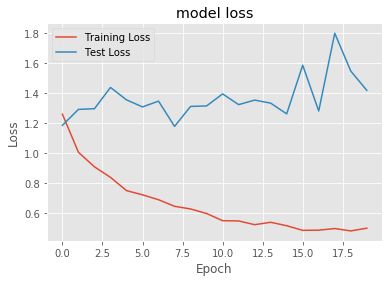

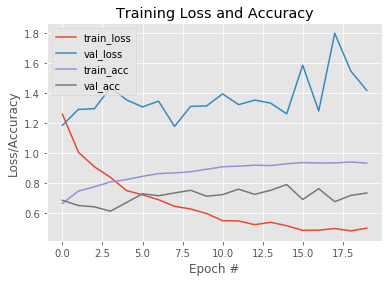

In [16]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [17]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  1.4524434614181518
Validation Accuracy:  0.76


In [20]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

603/603 [==============================] - ETA: 12:0 - ETA: 3:0 - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 49s - ETA: 41 - ETA: 36 - ETA: 33 - ETA: 31 - ETA: 29 - ETA: 26 - ETA: 25 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [21]:
predicts

array([[9.9999821e-01, 1.7471306e-06],
       [1.0000000e+00, 3.0156539e-08],
       [9.9999225e-01, 7.7274390e-06],
       ...,
       [9.9773514e-01, 2.2648133e-03],
       [9.6357143e-01, 3.6428604e-02],
       [1.0335868e-01, 8.9664137e-01]], dtype=float32)

In [22]:
len(predicts)

603

In [23]:
len(predict_class)

603

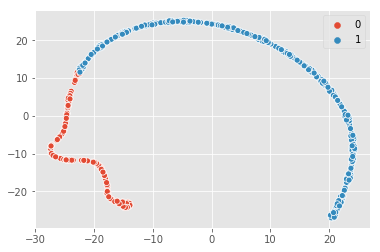

In [24]:
resnet50_predictions = np.vstack(predicts)
classes = np.hstack(predict_class)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(resnet50_predictions)

seaborn.scatterplot(tsne_data[:,0], tsne_data[:,1], hue=classes)

In [25]:
print ('sgd: ')
sgd = SGDClassifier(max_iter=1000, penalty='l2', random_state=42)
scores = cross_val_score(sgd, resnet50_predictions, classes, scoring='accuracy', n_jobs=-1)
print (scores.mean())

sgd: 
0.995016501650165


In [26]:
print ('random forest: ')
xgb = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
scores = cross_val_score(xgb, resnet50_predictions, classes, scoring='accuracy', n_jobs=-1)
print (scores.mean())

random forest: 
0.995016501650165


In [27]:
print ('xgboost: ')
xgb = xgboost.XGBClassifier(max_depth=2, n_estimators=1000, random_state=42)
scores = cross_val_score(xgb, resnet50_predictions, classes, scoring='accuracy', n_jobs=-1)
print (scores.mean())

xgboost: 
0.995016501650165


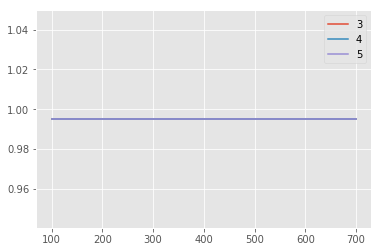

In [28]:
for depth in range(3, 6):
    scores = []
    for trees in range(100, 800, 100):
        xgb = xgboost.XGBClassifier(max_depth=depth, n_estimators=trees, random_state=42)
        score = cross_val_score(xgb, resnet50_predictions, classes, scoring='accuracy', n_jobs=-1, cv=3).mean()
        scores.append(score)
    plt.plot(range(100, 800, 100), scores, label=depth)
plt.legend()
plt.show()

In [ ]:
xgb = xgboost.XGBClassifier(max_depth=3, n_estimators=300, n_jobs=-1)
xgb.fit(resnet50_predictions, classes)

In [ ]:
preds = xgb.predict(resnet50_predictions)
print( "Accuracy: " + str(accuracy_score(classes, preds)))

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

In [ ]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [ ]:
# model.save('models/1.ResNet50-Combined-Model.h5')
# model.save_weights('models/1.ResNet50-Combined-Weights.h5')

___